## Predicting Voting Behavior ##

< TODO: Short Project Description Here >

### Set up ###

In [33]:
# Install missingno and h2o libraries
!python -m pip install missingno
!python -m pip install h2o
!python -m pip install xgboost

# Verify that java is installed (needed for h2o)
!java -version

openjdk version "20.0.1" 2023-04-18
OpenJDK Runtime Environment Homebrew (build 20.0.1)
OpenJDK 64-Bit Server VM Homebrew (build 20.0.1, mixed mode, sharing)


In [34]:
# Import libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import missingno as msno
from scipy.stats import chi2_contingency
import h2o
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

# Settings
pd.set_option('display.max_columns', None)

In [35]:
# Helper functions
def choose_random_color():
    colors = ['b', 'c', 'g', 'm', 'r', 'y', 'pink', 'turquoise', 'navy', 'lime', 'darkcyan', 'firebrick', 'slateblue', 'blueviolet']
    return random.choice(colors)


### Data cleaning and preprocessing ###

In [36]:
# Read in nonvoters dataset
non_voters = pd.read_csv('nonvoters_data.csv')
sample_size = len(non_voters)

# Print data types and non-null count for each feature  
non_voters.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5836 entries, 0 to 5835
Data columns (total 119 columns):
 #    Column          Non-Null Count  Dtype  
---   ------          --------------  -----  
 0    RespId          5836 non-null   int64  
 1    weight          5836 non-null   float64
 2    Q1              5836 non-null   int64  
 3    Q2_1            5836 non-null   int64  
 4    Q2_2            5836 non-null   int64  
 5    Q2_3            5836 non-null   int64  
 6    Q2_4            5836 non-null   int64  
 7    Q2_5            5836 non-null   int64  
 8    Q2_6            5836 non-null   int64  
 9    Q2_7            5836 non-null   int64  
 10   Q2_8            5836 non-null   int64  
 11   Q2_9            5836 non-null   int64  
 12   Q2_10           5836 non-null   int64  
 13   Q3_1            5836 non-null   int64  
 14   Q3_2            5836 non-null   int64  
 15   Q3_3            5836 non-null   int64  
 16   Q3_4            5836 non-null   int64  
 17   Q3_5        

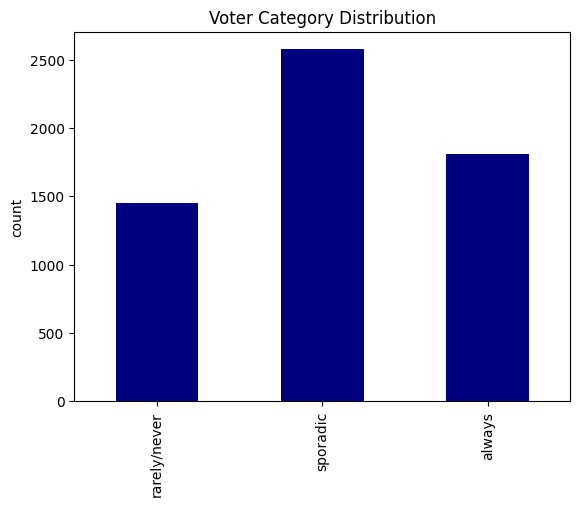

count    5836.000000
mean       51.693797
std        17.071561
min        22.000000
25%        36.000000
50%        54.000000
75%        65.000000
max        94.000000
Name: ppage, dtype: float64


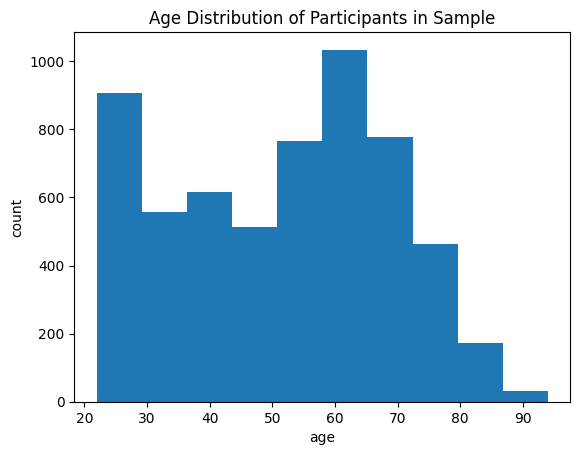

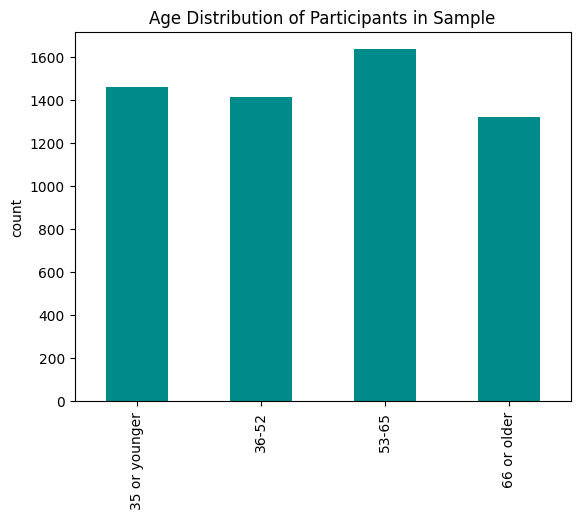

In [37]:
# Change categorical features to be of type category (this is all columns except RespId, weight, and ppage)
non_categorical = ['RespId', 'weight', 'ppage']
for column in non_voters.columns:
    if column not in non_categorical:
        non_voters[column] = non_voters[column].astype('category')

# Introduce ordering to demographic features with inherent ordering
non_voters.income_cat = pd.Categorical(non_voters.income_cat, ordered=True, categories=['Less than $40k', '$40-75k', '$75-125k', '$125k or more'])
non_voters.educ = pd.Categorical(non_voters.educ, ordered=True, categories=['High school or less', 'Some college', 'College'])
non_voters.voter_category = pd.Categorical(non_voters.voter_category, ordered=True, categories=['rarely/never', 'sporadic', 'always'])

# Examine target variable distribution
non_voters.voter_category.value_counts().sort_index().plot(kind='bar', color=choose_random_color())
plt.title('Voter Category Distribution')
plt.ylabel('count')
plt.show()

# Examine age distribution of participants
print(non_voters.ppage.describe())

plt.hist(non_voters.ppage)
plt.title('Age Distribution of Participants in Sample')
plt.xlabel('age')
plt.ylabel('count')
plt.show()
plt.clf()

# Convert age feature to be catgorical instead of quantitative to improve interpretability
non_voters.ppage = pd.cut(non_voters.ppage, bins=[0, 36, 53, 66, 99], labels=['35 or younger', '36-52', '53-65', '66 or older'])
non_voters.ppage = pd.Categorical(non_voters.ppage, ordered=True, categories=['35 or younger', '36-52', '53-65', '66 or older'])

# Examine new distribtuion
non_voters.ppage.value_counts().sort_index().plot(kind='bar', color=choose_random_color())
plt.title('Age Distribution of Participants in Sample')
plt.ylabel('count')
plt.show()

        ppage     educ   race gender income_cat voter_category
count    5836     5836   5836   5836       5836           5836
unique      4        3      4      2          4              3
top     53-65  College  White   Male   $75-125k       sporadic
freq     1637     2330   3710   2940       1628           2574


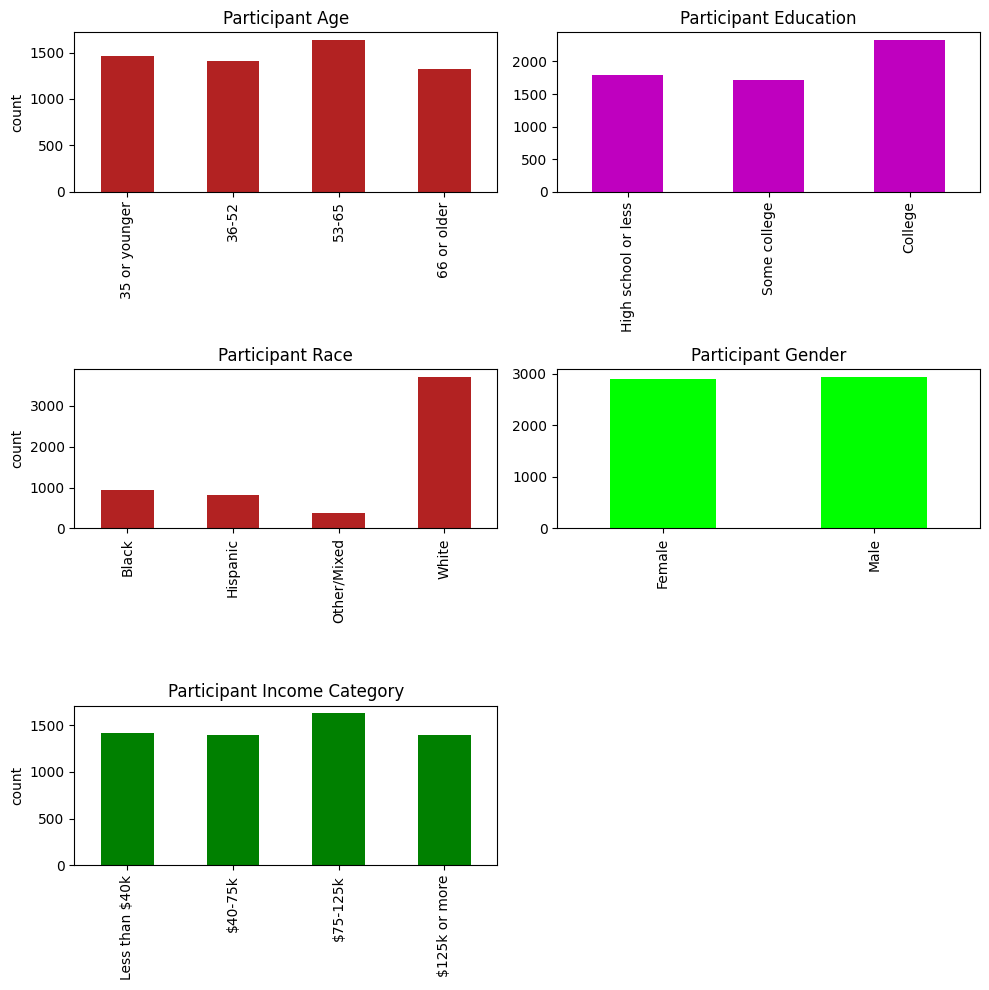

In [38]:
# Examine demographics of participants in the dataset
voter_demographics = non_voters[['ppage', 'educ', 'race', 'gender', 'income_cat', 'voter_category']].copy()
print(voter_demographics.describe(include='all'))

# Visualize distribution of participant demographics
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
voter_demographics.ppage.value_counts().sort_index().plot(ax=ax[0, 0], kind='bar', color=choose_random_color())
ax[0, 0].set_title('Participant Age')
ax[0, 0].set_ylabel('count')

voter_demographics.educ.value_counts().sort_index().plot(ax=ax[0, 1], kind='bar', color=choose_random_color())
ax[0, 1].set_title('Participant Education')

voter_demographics.race.value_counts().sort_index().plot(ax=ax[1, 0], kind='bar', color=choose_random_color())
ax[1, 0].set_title('Participant Race')
ax[1, 0].set_ylabel('count')

voter_demographics.gender.value_counts().sort_index().plot(ax=ax[1, 1], kind='bar', color=choose_random_color())
ax[1, 1].set_title('Participant Gender')

voter_demographics.income_cat.value_counts().sort_index().plot(ax=ax[2, 0], kind='bar', color=choose_random_color())
ax[2, 0].set_title('Participant Income Category')
ax[2, 0].set_ylabel('count')

ax[2, 1].axis('off')

plt.tight_layout()
plt.show()
    

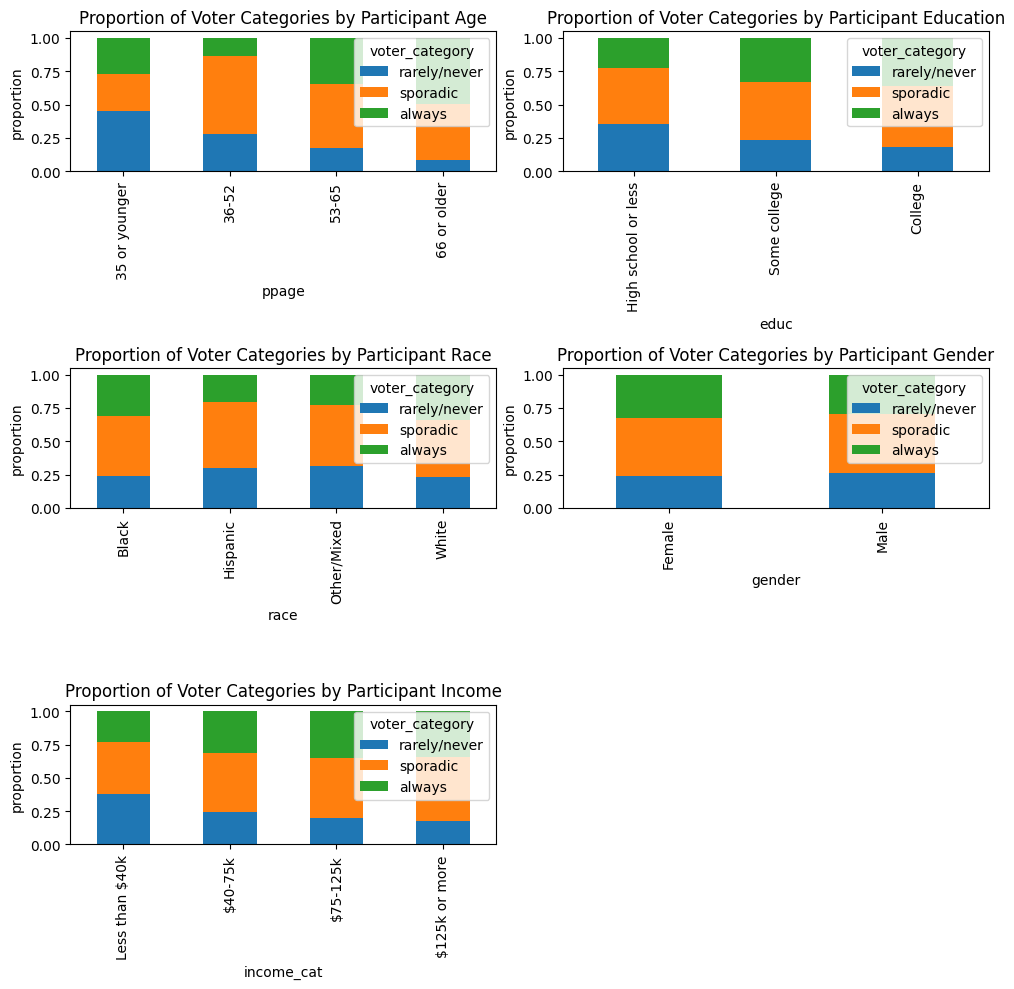

In [39]:
# Examine voter demographics compared to voter category
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
voter_demographics.groupby(['ppage', 'voter_category']).size().unstack().apply(
    lambda x: x / x.sum(), axis=1).plot(ax=ax[0, 0], kind='bar', stacked=True)
ax[0, 0].set_title('Proportion of Voter Categories by Participant Age')
ax[0, 0].set_ylabel('proportion')

voter_demographics.groupby(['educ', 'voter_category']).size().unstack().apply(
    lambda x: x / x.sum(), axis=1).plot(ax=ax[0, 1], kind='bar', stacked=True)
ax[0, 1].set_title('Proportion of Voter Categories by Participant Education')
ax[0, 1].set_ylabel('proportion')

voter_demographics.groupby(['race', 'voter_category']).size().unstack().apply(
    lambda x: x / x.sum(), axis=1).plot(ax=ax[1, 0], kind='bar', stacked=True)
ax[1, 0].set_title('Proportion of Voter Categories by Participant Race')
ax[1, 0].set_ylabel('proportion')

voter_demographics.groupby(['gender', 'voter_category']).size().unstack().apply(
    lambda x: x / x.sum(), axis=1).plot(ax=ax[1, 1], kind='bar', stacked=True)
ax[1, 1].set_title('Proportion of Voter Categories by Participant Gender')
ax[1, 1].set_ylabel('proportion')

voter_demographics.groupby(['income_cat', 'voter_category']).size().unstack().apply(
    lambda x: x / x.sum(), axis=1).plot(ax=ax[2, 0], kind='bar', stacked=True)
ax[2, 0].set_title('Proportion of Voter Categories by Participant Income')
ax[2, 0].set_ylabel('proportion')

ax[2, 1].axis('off')

plt.tight_layout()
plt.show()

In [40]:
# Perform one-hot encoding on race column since it is not binary and not ordinal
non_voters = pd.concat([non_voters, pd.get_dummies(non_voters['race'])], axis=1)
non_voters.drop(columns=['race'], axis=1, inplace=True)

voter_demographics = non_voters[['ppage', 'educ', 'gender', 'income_cat', 'Black', 'Hispanic', 'Other/Mixed', 'White']].copy()

In [41]:
# Remove column for question 1 since every participant answered yes (prerequiste for being included in the sample)
non_voters.drop(f'Q1', axis=1, inplace=True)

# Remove columns for question 19 because it has a different format than the other questions
for i in range(1, 11):
    non_voters.drop(f'Q19_{i}', axis=1, inplace=True)

# Check for NA values
na_feature_count = 0
na_columns = []
for column in non_voters.columns:
    na_values = non_voters[column].isna().sum()
    if(na_values > 0):
        na_columns.append(column)
        na_feature_count += 1

print(f'{na_feature_count} features have NA values.')
print(na_columns)

# Drop all columns with NA values since they represent questions asked to a subset of participants
non_voters.drop(na_columns, axis=1, inplace=True)

22 features have NA values.
['Q22', 'Q28_1', 'Q28_2', 'Q28_3', 'Q28_4', 'Q28_5', 'Q28_6', 'Q28_7', 'Q28_8', 'Q29_1', 'Q29_2', 'Q29_3', 'Q29_4', 'Q29_5', 'Q29_6', 'Q29_7', 'Q29_8', 'Q29_9', 'Q29_10', 'Q31', 'Q32', 'Q33']


Q2_1                 Answered  Did Not Answer
educ                                         
High school or less      1773              23
Some college             1704               6
College                  2324               6
chi statistic: 20.321547041372234
p-value: 3.865735433536265e-05
185 significant relationships found out of 624.


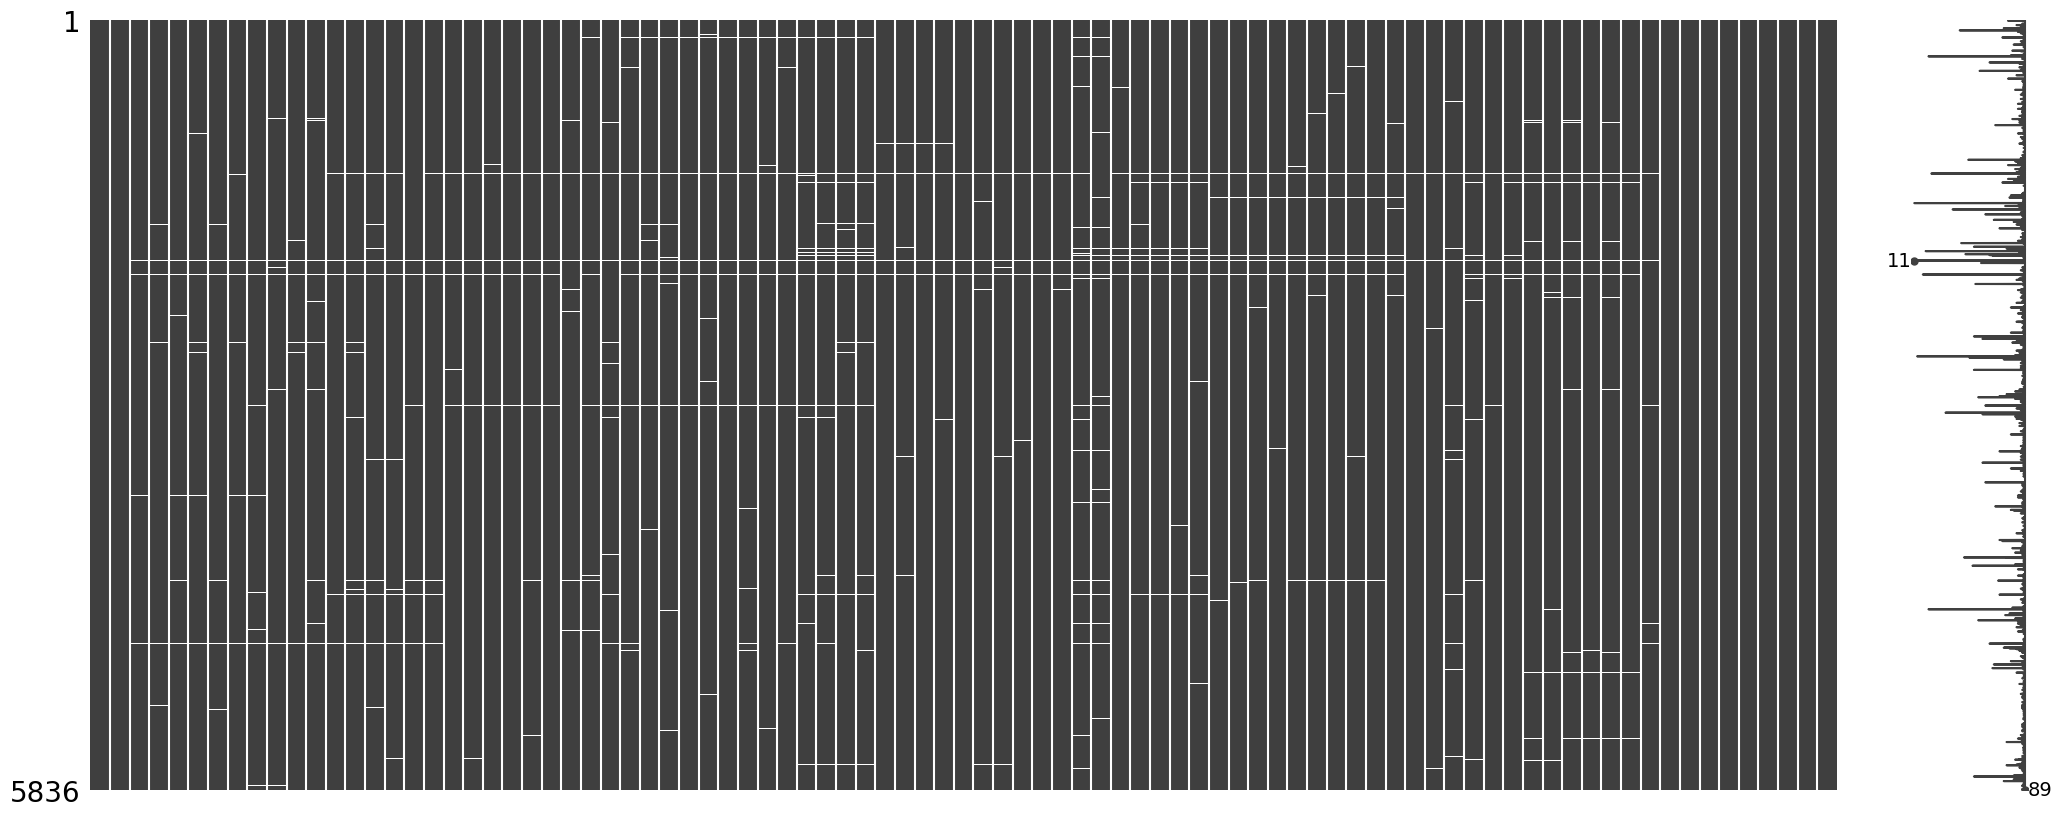

In [42]:
# Replace remaining -1 missing values with nan for easier analysis
non_voters = non_voters.replace(-1, np.nan)

# Use a missingno matrix to visually inspect if missing values are MCAR (missing completely at random)
msno.matrix(non_voters)

# Since the missingness looks like it might not be MCAR, use chi-square tests to check if there is a signigicant relationship 
# between participant demographics and missing values, which could indicate that there is additional information in the missing values
# Chose one variable pair to test
contingency_table = pd.crosstab(non_voters['educ'], non_voters['Q2_1'].isna())
contingency_table = contingency_table.rename(columns={False: "Answered", True: "Did Not Answer"})
print(contingency_table)
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f'chi statistic: {chi2}')
print(f'p-value: {p}')

# Test the other variables
questions = non_voters.filter(like='Q')
significant_count = 0
total_relationships = 0
for q in questions.columns:
    for d in voter_demographics.columns:
        total_relationships += 1
        # Create a contingency table
        contingency_table = pd.crosstab(non_voters[d], non_voters[q].isna())

        # Perform chi-square test
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        # Set significance level for interpreting p-value
        alpha = 0.05
        if p <= alpha:
            significant_count += 1

if not significant_count:
    print('There was no significant relationship found between demographic variables and missing values.')
else:
    print(f'{significant_count} significant relationships found out of {total_relationships}.')



In [43]:
relationships = []
items = non_voters.drop(['RespId', 'weight', 'voter_category'], axis=1).copy()
for q in items.columns:
    for d in items.columns:
        if q != d:
            # Create a contingency table
            contingency_table = pd.crosstab(non_voters[d], non_voters[q])

            # Perform chi-square test
            chi2, p, dof, expected = chi2_contingency(contingency_table)

            relationships.append((q, d, chi2))

sorted_relationships = sorted(relationships, key=lambda x: x[2], reverse=True)

for r in sorted_relationships:
    print(r)

('Q4_2', 'Q4_3', 5229.161850828985)
('Q4_3', 'Q4_2', 5229.161850828985)
('Q4_1', 'Q4_2', 4744.591694842289)
('Q4_2', 'Q4_1', 4744.591694842289)
('Q2_4', 'Q2_6', 4197.648747953489)
('Q2_6', 'Q2_4', 4197.648747953489)
('Q23', 'Q30', 4024.4657618925835)
('Q30', 'Q23', 4024.4657618925835)
('Q3_1', 'Q3_2', 3966.638202051684)
('Q3_2', 'Q3_1', 3966.638202051684)
('Q27_3', 'Q27_5', 3810.6506892077846)
('Q27_5', 'Q27_3', 3810.6506892077846)
('Q17_1', 'Q17_2', 3732.955508066592)
('Q17_2', 'Q17_1', 3732.9555080665914)
('Q27_2', 'Q26', 3692.0436560878716)
('Q26', 'Q27_2', 3692.043656087871)
('Q21', 'Q26', 3611.1531098333835)
('Q26', 'Q21', 3611.1531098333835)
('Q26', 'Q20', 3430.7225951678674)
('Q20', 'Q26', 3430.7225951678665)
('Q3_4', 'Q8_7', 3353.617421712715)
('Q8_7', 'Q3_4', 3353.617421712715)
('Q14', 'Q23', 3336.9022566146004)
('Q23', 'Q14', 3336.9022566146004)
('Q27_4', 'Q27_6', 3325.369730012412)
('Q27_6', 'Q27_4', 3325.369730012412)
('Q8_1', 'Q23', 3186.741508917834)
('Q23', 'Q8_1', 3186.

### Training the model ###

In [44]:
# Initialize the h2o cluster
h2o.init()

# Convert the pandas DataFrame to an h2o Frame
non_voters_h2o = h2o.H2OFrame(non_voters)

# Input parameters that are going to train, use all explanatory variables for first pass
training_columns = [c for c in non_voters.columns if c not in ['RespId', 'weight', 'voter_category']]

# Output parameter train against input parameters
response_column = 'voter_category'

# Split cleaned dataset into training and test sets (80% for training, 20% for testing)
train, test = non_voters_h2o.split_frame(ratios=[0.8], seed=42)

# Check the dimensions of the splits
print("Training set shape:", train.shape)
print("Test set shape:", test.shape)

# Set hyperparameters
ntrees = 100
max_depth = 10
nfolds = 10

# Define model
model = h2o.estimators.H2ORandomForestEstimator(ntrees=ntrees, max_depth=max_depth, nfolds=nfolds)

# Train model
model.train(x=training_columns, y=response_column, training_frame=train, weights_column='weight')

# Model performance
performance = model.model_performance(test_data=test)

print(performance)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "20.0.1" 2023-04-18; OpenJDK Runtime Environment Homebrew (build 20.0.1); OpenJDK 64-Bit Server VM Homebrew (build 20.0.1, mixed mode, sharing)
  Starting server from /opt/homebrew/anaconda3/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/8d/zjs9s_1s6njg6wx3_cvk_l5c0000gn/T/tmp9s3ve48z
  JVM stdout: /var/folders/8d/zjs9s_1s6njg6wx3_cvk_l5c0000gn/T/tmp9s3ve48z/h2o_juliet_started_from_python.out
  JVM stderr: /var/folders/8d/zjs9s_1s6njg6wx3_cvk_l5c0000gn/T/tmp9s3ve48z/h2o_juliet_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,1 month and 26 days
H2O_cluster_name:,H2O_from_python_juliet_hj7kco
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training set shape: (4683, 89)
Test set shape: (1153, 89)
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
ModelMetricsMultinomial: drf
** Reported on test data. **

MSE: 0.27312380978072665
RMSE: 0.5226124852897476
LogLoss: 0.7671345579518901
Mean Per-Class Error: 0.38747615735782975
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
always    rarely/never    sporadic    Error     Rate
--------  --------------  ----------  --------  -----------
171       25              162         0.522346  187 

### Feature Selection ###

In [45]:
# Examine feature importance from the first pass model
imp = model.varimp()
for feature, imp, scaled_imp, percent in imp:
    print(f'{feature}: {scaled_imp}')


Q26: 1.0
Q27_4: 0.5573244945826229
Q27_2: 0.534005754917494
Q27_6: 0.49397345589519226
Q27_1: 0.43834450874715825
ppage: 0.3341433294950833
Q27_3: 0.24803353487454416
Q21: 0.23758988395831399
Q27_5: 0.1818205076484269
Q20: 0.17627825038056397
Q2_1: 0.15759162506566962
Q30: 0.0797361081782831
income_cat: 0.07457704576490917
Q25: 0.06367303012103122
Q2_2: 0.06218252990019479
Q15: 0.05876377139985094
Q14: 0.0577109110843633
educ: 0.05502875584047625
Q2_3: 0.053674868429186555
Q17_4: 0.05255170688700276
Q9_3: 0.04994896249095182
Q16: 0.04949448179874853
Q9_2: 0.04813662443583364
Q6: 0.048103427290745585
Q4_5: 0.04783657407416159
Q24: 0.04733514712861276
Q9_4: 0.04589479905459698
Q5: 0.04507496465955365
Q2_10: 0.04488632500380769
Q3_3: 0.04482369586616499
Q4_4: 0.044588830692338766
Q8_8: 0.044479267116682736
Q4_3: 0.04440715420571319
Q23: 0.044396902435792175
Q2_5: 0.0440377517823665
Q8_2: 0.04403596372875753
Q2_4: 0.043957486292166635
Q8_6: 0.04347129718673474
Q17_1: 0.043388507153884336
Q

In [46]:
# Conduct Cramer's v test to find explanatory variables with strongest association
cramer_v_values = []
for column in non_voters.columns:
    if column not in ['voter_category', 'RespId', 'weight']:
        contingency_table = pd.crosstab(non_voters[column], non_voters['voter_category'])
        x2 = chi2_contingency(contingency_table)[0]
        n = contingency_table.sum().sum()
        min_dim = min(contingency_table.shape) - 1
        cramer_v = np.sqrt((x2/n) / min_dim)
        cramer_v_values.append((column, cramer_v))

# Sort the Cramer's V values in descending order
sorted_cramer_v = sorted(cramer_v_values, key=lambda x: x[1], reverse=True)
print(sorted_cramer_v)

# Print the sorted Cramer's V values by association level
very_strong = [(k,v) for (k, v) in sorted_cramer_v if v >= 0.5]
moderately_strong = [(k,v) for (k, v) in sorted_cramer_v if v >= 0.3 and v < 0.5]
moderate = [(k,v) for (k, v) in sorted_cramer_v if v >= 0.2 and v < 0.3]
weak = [(k,v) for (k, v) in sorted_cramer_v if v >= 0.15 and v < 0.2]

print('Very Strong Association:')
for feature, value in very_strong:
    print(f'{feature}: {value}')
print('\nModerately Strong Association:')
for feature, value in moderately_strong:
    print(f'{feature}: {value}')
print('\nModerate Association:')
for feature, value in moderate:
    print(f'{feature}: {value}')
print('\nWeak Association:')
for feature, value in weak:
    print(f'{feature}: {value}')


[('Q27_2', 0.6243952642015779), ('Q27_4', 0.5913994693428056), ('Q27_1', 0.5451781739990903), ('Q27_6', 0.5408805486855754), ('Q27_3', 0.52899786208004), ('Q27_5', 0.5123257155625766), ('Q20', 0.4928292813942399), ('Q26', 0.4864294241599487), ('Q21', 0.34683232961966376), ('Q2_1', 0.3073270234190789), ('ppage', 0.2724551150405875), ('Q5', 0.2477988508228831), ('Q25', 0.24500093224334418), ('Q2_3', 0.1975317032370354), ('Q2_2', 0.19639611018438957), ('Q30', 0.18631248338452275), ('Q2_5', 0.17077878562055976), ('Q9_1', 0.1677326348608688), ('Q6', 0.1625454285146432), ('Q16', 0.1571410788092562), ('Q11_5', 0.1557695988532879), ('Q23', 0.14980174095405885), ('Q18_3', 0.13867352645505174), ('Q17_1', 0.13503926880751085), ('Q17_2', 0.1336448209672957), ('Q4_2', 0.1333836618058866), ('income_cat', 0.13035475321196904), ('Q9_4', 0.12701195612654206), ('educ', 0.12485365762440266), ('Q2_7', 0.1225384752304419), ('Q8_5', 0.12106960750901047), ('Q4_1', 0.11970217993840894), ('Q9_3', 0.11802905691

In [47]:
# Create reduced feature sets based on feature importance and cramer's v association
very_strong_features = [k for k, _ in very_strong]
moderately_strong_features = [k for k, _ in moderately_strong]
moderate_features = [k for k, _ in moderate]
weak_features = [k for k, _ in weak]
training_columns = very_strong_features + moderately_strong_features + moderate_features
print(training_columns)

['Q27_2', 'Q27_4', 'Q27_1', 'Q27_6', 'Q27_3', 'Q27_5', 'Q20', 'Q26', 'Q21', 'Q2_1', 'ppage', 'Q5', 'Q25']


In [48]:
# Run model again with reduced feature set
model = h2o.estimators.H2ORandomForestEstimator(ntrees=ntrees, max_depth=max_depth, nfolds=nfolds)

# Train model
model.train(x=training_columns, y=response_column, training_frame=train, weights_column='weight')

# Model performance
performance = model.model_performance(test_data=test)

print(performance)

drf Model Build progress: |

██████████████████████████████████████████████████████| (done) 100%
ModelMetricsMultinomial: drf
** Reported on test data. **

MSE: 0.26950312386213804
RMSE: 0.5191369028128688
LogLoss: 0.7783098366811724
Mean Per-Class Error: 0.38419427114723637
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
always    rarely/never    sporadic    Error     Rate
--------  --------------  ----------  --------  -----------
248       25              85          0.307263  110 / 358
54        187             57          0.372483  111 / 298
213       22              262         0.472837  235 / 497
515       234             404         0.39549   456 / 1,15

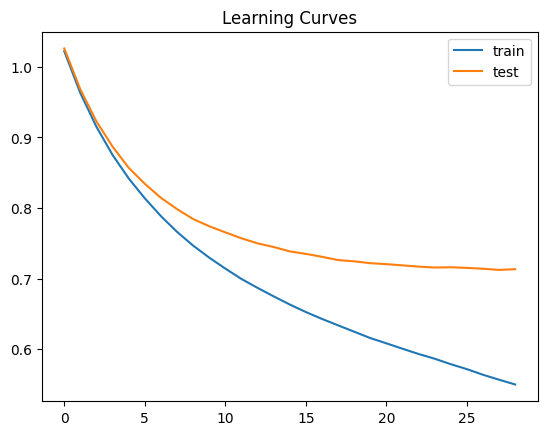

Accuracy: 0.6952054794520548
Log Loss: 0.7132808648461272
Confusion Matrix:
[[ 99  34  17]
 [  8 196  56]
 [  4  59 111]]


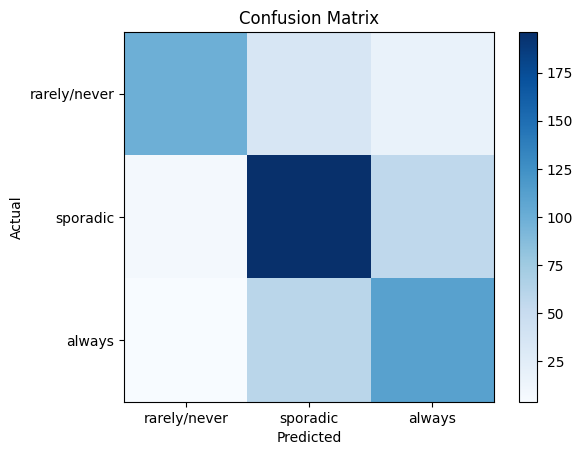

In [60]:
# Configure training features and target
X = non_voters.drop(['RespId', 'voter_category'], axis=1).copy()
y = non_voters['voter_category'].cat.codes

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
weights = X_train['weight']
X_train.drop('weight', axis=1, inplace=True)
X_test.drop('weight', axis=1, inplace=True)

# Define the datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test,y_test)]

# Create an XGBoost classifier
model = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, n_estimators=29, eta=0.16, eval_metric='mlogloss')

# Fit the model
model.fit(X_train, y_train, sample_weight=weights, verbose=False, eval_set=evalset)

# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred_probabilities = model.predict_proba(X_test)

# Plot learning curves
results = model.evals_result()
plt.plot(results['validation_0']['mlogloss'], label='train')
plt.plot(results['validation_1']['mlogloss'], label='test')
plt.title('Learning Curves')
plt.legend()
plt.show()

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate the log loss score
logloss = log_loss(y_test, y_pred_probabilities)
print(f'Log Loss: {logloss}')

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{cm}')

# Plot confusion matrix
classes = ['rarely/never', 'sporadic', 'always']
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=range(len(classes)), labels=classes)
plt.yticks(ticks=range(len(classes)), labels=classes)
plt.show()